[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/guiwitz/DLImaging/blob/master/notebooks/09-TransferLearning_drawings.ipynb)

# Transfer learning

Most successful models have been trained on very large datasets, e.g  ImageNet, either by academic or private groups. If we are considering a convolutional network, this means that all filters in the network have been optimized to recognize specific features. If we want to use the same model architecture for a different problem (e.g. not one contained in the 1000 categories of ImageNet), we can't directly use such a pre-trained network. However we *can* keep most of the trained network which is super efficient at extracting information and adjust *only the last layer(s)* which do the classification.

In [1]:
from IPython.display import HTML, display, Image

# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/MLCV/main/notebooks/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

In [2]:
Image(url='https://github.com/guiwitz/DLImaging/raw/master/illustrations/fine_tuning.jpg',width=800)

## Import a pre-trained network

We have already seen before that it is very simple to import pre-trained networks. We are going to use a ResNet model this time: 

In [3]:
import torchvision.models as models
import torch
from torch import nn

We wan check the content of the model:

In [4]:
model = models.resnet18(pretrained=True)

/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
for name, module in model.named_children():
    print(f'name: {name} module: {module}')

name: conv1 module: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
name: bn1 module: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
name: relu module: ReLU(inplace=True)
name: maxpool module: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
name: layer1 module: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(i

We see that the classifier is only the very last layer ```fc``` which takes 512 inputs and outputs probabilities (not scaled) for 1000 categories (Imagenet). We want to now do two things: 
1. modify the last layer to output only 3 categories

In [6]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [7]:
model.fc = nn.Linear(512, 3, bias=True)

2. Make all the parameters non-trainable as we want to keep the trained filters as they are, **except** for the ```fc``` layer. To make parameters non-trainable we can simply use the ```requires_grad``` parameter. Let's check how many trainable parameters we have right now:

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
count_parameters(model)

11178051

Now we set all parameters as non-trainable:

In [10]:
for p in model.parameters():
    p.requires_grad = False

In [11]:
count_parameters(model)

0

And set only the very last ```fc``` layer to trainable again:

In [12]:
for p in model.fc.parameters():
    p.requires_grad = True

In [13]:
count_parameters(model)

1539

In [35]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

## Dataset

We use again here our dataset of quickdraw. Note that those images are just gray scale images with a single channel. However if we look at the first layer in the network, we have:

In [15]:
model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

As we can see, the model expects three channels! What we can simply do is create a multi-channel image by repeating the single channel. Once way of doing this is to use the ```repeat``` method and specify that we want to repeat the first axis (channel) three times ```x = x.repeat(3,1,1)```:

In [16]:
class Drawings(Dataset):
    """Dataset class for quickdraw. Inputs are arrays of linearized 
    images and arrays of labels."""
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        x = np.reshape(x, (28,28))
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)
            x = x.repeat(3,1,1)

        return x, y

    def __len__(self):
        return len(self.targets)
    
transformations = transforms.Compose([
    transforms.ToTensor(),
])

num_data = 1000
batch_size = 50

folders = list(datapath.joinpath('data/quickdraw').glob('*npy'))
label_dict = {i:f.name.split('_')[-1][:-4] for i, f in enumerate(folders)}

data = np.concatenate([np.load(f)[0:num_data] for f in folders]) #check everything works with tiny set
labels = np.concatenate([[ind for i in range(num_data)] for ind, f in enumerate(folders)]) #check everything works with tiny set

rng = np.random.default_rng()
indices = rng.choice(len(data), size=len(data), replace=False)

train_loader = DataLoader(Drawings(data, labels, transformations),
                          sampler=indices[0:int(0.8*len(data))], batch_size=batch_size)
valid_loader = DataLoader(Drawings(data, labels, transformations),
                          sampler=indices[int(0.8*len(data))::], batch_size=batch_size)

In [17]:
image_batch, label_batch = next(iter(train_loader))
image1 = image_batch[0]
image1.shape

torch.Size([3, 28, 28])

## Model

Knowing this, we can integrate now the model and the data pre-processing in a module:

In [18]:
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="draw")

class Myresnet(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, num_categories=3):
        super(Myresnet, self).__init__()
        
        
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(512, num_categories, bias=True)
        for p in model.parameters():
            p.requires_grad = False
        for p in model.fc.parameters():
            p.requires_grad = True
        
        self.model = model
        self.loss = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        
        # define the sequence of operations in the network including e.g. activations
        x = self.model(x)
                
        return x
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output, y)
        
        self.log('Loss/train', loss, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        accuracy = (torch.argmax(output,dim=1) == y).sum()/len(y)

        self.log('Accuracy/validation', accuracy, on_epoch=True, prog_bar=True, logger=True)

        return accuracy
        
    def configure_optimizers(self):

        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

## Training

Finally we can train the network, or rather the *last layer* of the network. We see in the information output from Lightning that we have 11M parameters but only 1K *trainable* ones which is what we expected.

In [20]:
if 'myresnet' in locals():
    del myresnet
myresnet = Myresnet(num_categories=3)

/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="draw")

In [22]:
trainer = pl.Trainer(max_epochs=10, logger=logger)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [23]:
trainer.fit(myresnet, train_dataloaders=train_loader, val_dataloaders=valid_loader)

Missing logger folder: tb_logs/draw

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.5 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [24]:
%load_ext tensorboard
%tensorboard --logdir tb_logs

Reusing TensorBoard on port 6006 (pid 19759), started 12:56:50 ago. (Use '!kill 19759' to kill it.)

## Testing the result

We see that we have achieved a good accuracy in just a few epochs. We check visually on a validation batch the result of our network.

In [25]:
test_batch, test_label = next(iter(valid_loader))

pred_label = myresnet(test_batch)
pred_label = pred_label.argmax(dim=1)

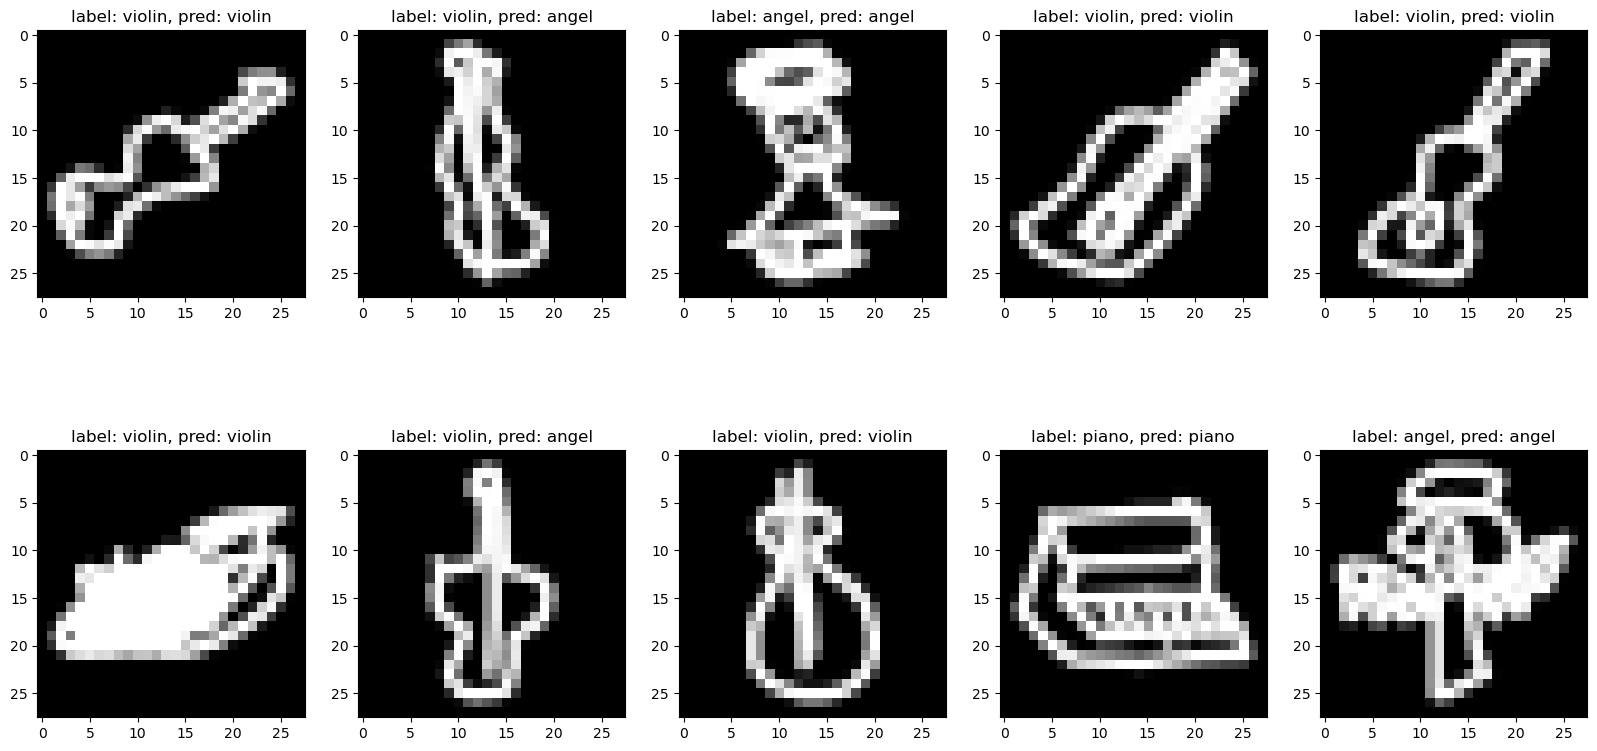

In [33]:
fig, axes = plt.subplots(2,5,figsize=(20,10))

for count, ax in enumerate(axes.ravel()):
    ax.imshow(test_batch[count,0,:,:],cmap='gray')
    ax.set_title(f'label: {label_dict[test_label[count].item()]}, pred: {label_dict[pred_label[count].item()]}')

## Fine tuning

The above problem is relatively simple as we have two classes. But in many cases, it might be necessary to go one step further and to *fine-tune* the entire network, i.e. unfreeze the layers that we set to ```requires_grad = False```. When we do this, we want to use a smaller learning rate as we don't want to completely disturb the network which has been carefully trained on a very large dataset.

Generally, great care has to be taken when trying to fine-tune a system, and one has many options: one could use different learning rates for different layers, unfreeze only part of the convolution layers etc. but this goes beyond the frame of this course.

For the moment we just unfreeze the network and lower the learning rate by a factor of 10. Training the entire network is also interesting here because this will allow us to explore more in detail what features are important for the image classification.

In [36]:
if 'myresnet' in locals():
    del myresnet
myresnet = Myresnet(learning_rate=1e-4, num_categories=3)

/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
for p in myresnet.parameters():
    p.requires_grad = True

In [38]:
logger = TensorBoardLogger("tb_logs", name="draw_finetune")
trainer = pl.Trainer(max_epochs=10, logger=logger)
trainer.fit(myresnet, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Missing logger folder: tb_logs/draw_finetune

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


We see that here again we obtain a very good result with a validation accuracy that increases and starts to plateau around 1. If we would run many more epochs, we would probably see the validation accuracy start to dip because of over-training and disruption of the finely adjusted network that we inherited.

## Checking that training actually works

Sometimes one mixes up training and validation data or there is a bug in the code that makes it look like training is very efficient while it's not. A good way to check this is to just jumble the labels on a small dataset: here the loss in the training will still go down but only because the network learns each image by heart, not because it discovers general rules. In contrast when applied to the validation data, the model will generate more or less random results (30% here)!

In [50]:
num_data = 200
batch_size = 20

data = np.concatenate([np.load(f)[0:num_data] for f in folders]) #check everything works with tiny set

#///// Here we replace labels by random ones ////////////
#labels = np.concatenate([[ind for i in range(num_data)] for ind, f in enumerate(folders)]) #check everything works with tiny set
labels = np.random.randint(0,3, len(labels))

rng = np.random.default_rng()
indices = rng.choice(len(data), size=len(data), replace=False)

train_loader = DataLoader(Drawings(data, labels, transformations),
                          sampler=indices[0:int(0.8*len(data))], batch_size=batch_size)
valid_loader = DataLoader(Drawings(data, labels, transformations),
                          sampler=indices[int(0.8*len(data))::], batch_size=batch_size)

if 'badresnet' in locals():
    del badresnet
badresnet = Myresnet(learning_rate=1e-3, num_categories=3)

for p in badresnet.parameters():
    p.requires_grad = True
    
logger = TensorBoardLogger("tb_logs", name="draw_finetune")
trainer = pl.Trainer(max_epochs=20, logger=logger)
trainer.fit(badresnet, train_dataloaders=train_loader, val_dataloaders=valid_loader)

/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used.

Sanity Checking: 0it [00:00, ?it/s]

/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## Interpretability

Finally we can again play the game of interpretability to understand what parts of the image the network uses for classification. Normally, like with the drawings, we should see the worms themselves as important elements.

In [51]:
from captum.attr import Saliency
from captum.attr import visualization as viz

We need to unfreeze all parameters (if not already done):

In [52]:
for p in myresnet.parameters():
    p.requires_grad = True

Then we calculate the ```saliency``` map for a series of images. We should not forget to add the input images to the gradient calculation using ```requires_grad```. We also use here a plotting function comming directly from the Captum package:

In [53]:
test_batch, test_label = next(iter(valid_loader))

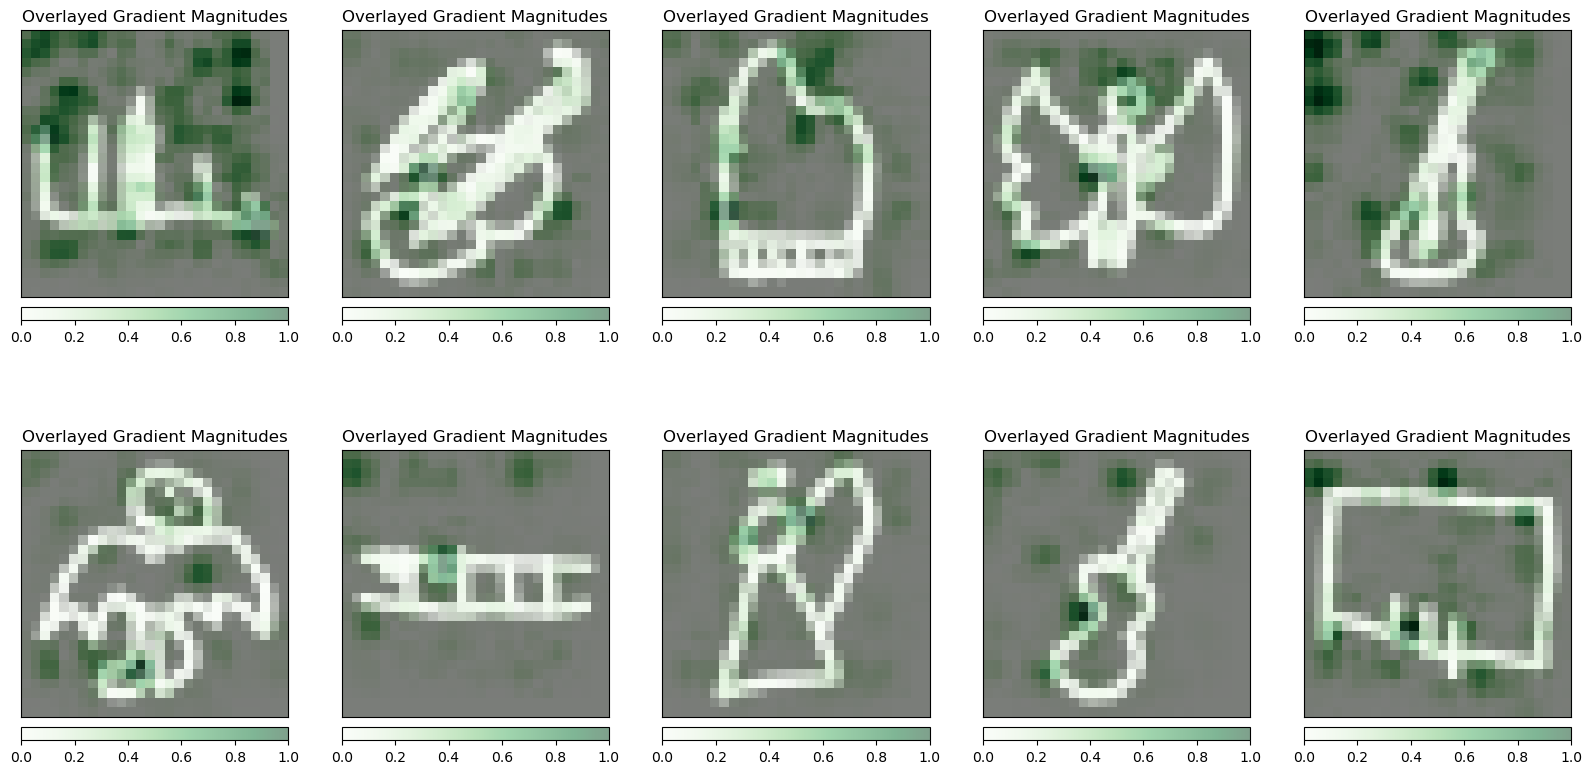

In [55]:
fig, axes = plt.subplots(2,5, figsize=(20,10))

for ind, ax in enumerate(axes.ravel()): 
        
    myinput = test_batch[ind].unsqueeze(0)
    myinput.requires_grad = True
    myresnet.eval()

    saliency = Saliency(myresnet)
    grads = saliency.attribute(myinput, target=test_label[ind].item())
    grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
    original_image = myinput.detach().numpy()[0]
    original_image = np.rollaxis(original_image,0,3)
    ind+=1

    _ = viz.visualize_image_attr(grads, original_image, cmap='Greens', method="blended_heat_map", sign="absolute_value",
                      show_colorbar=True, title="Overlayed Gradient Magnitudes", plt_fig_axis = (fig, ax),use_pyplot=False)